In [210]:
# ANN OCR trained with Noise
# numpy/tensorflow/keras
#
# ICIN/IC Ex1 - Ago/2018 - Adolfo Bauchspiess 

import numpy as np

from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.lines as lines

import tensorflow as tf
 
import geraChar


N=6   # Levels of noise
Nnt=10 # Number of training noise samples for each noise level
Nnv=20 # Number of validating noise samples
NStep=10  # Noise step

P=[]  # Pattern
T=[]  # Target
Pn=[] # Noise Pattern
fitT=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training
fitV=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training


In [211]:
# create models with 0, 10, 20 .... 90% noisy bit
(P,T)=geraChar.geraChar()

# Creat a set of N ANNs
Models=[]
for i in range(N): # for each model    
    model = Sequential()
    model.add(Dense(units=32, activation="sigmoid", kernel_initializer="uniform", input_dim=63))
    model.add(Dense(units=24, activation="sigmoid", kernel_initializer="uniform"))
    model.add(Dense(units=16, activation="sigmoid", kernel_initializer="uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    Models.append(model)
    
print("Train networks")   
Models[0].fit(P, T, epochs=3000, batch_size=1, verbose=0)

Train networks


In [212]:

for i in range(1,N): # for each model
# Learn Nstep epochs Noise Chars + epochs reforcing orig. Chars.
                            
    # Mantain Models[i-1] and proceed training with noise
    Models[i].set_weights(Models[i-1].get_weights())
                            
    # test with different noise levels (at least once - range(i+1))
    for k in range(Nnt):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        Models[i].fit(Pn, T, epochs=30, batch_size=1, verbose=0)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitT[i] += incorr
         
    #Pn = geraChar.gchar_ruido(P,0) # Reforce learning without noise 
    Models[i].fit(P, T, epochs=200, batch_size=1, verbose=0)
    (incorr,idx) = geraChar.validacao(P,Models[i])
    fitT[i] += incorr

    print("Rede i",i,"incorr",str(np.round(fitT[i],2)))
 

1/1 [==============================] - 0s 21ms/step
Rede i 1 incorr 0
1/1 [==============================] - 0s 29ms/step
Rede i 2 incorr 1
1/1 [==============================] - 0s 18ms/step
Rede i 3 incorr 2
1/1 [==============================] - 0s 30ms/step
Rede i 4 incorr 8
1/1 [==============================] - 0s 19ms/step
Rede i 5 incorr 6


In [213]:
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

Model: "sequential_254"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_658 (Dense)           (None, 32)                2048      
                                                                 
 dense_659 (Dense)           (None, 24)                792       
                                                                 
 dense_660 (Dense)           (None, 16)                400       
                                                                 
Total params: 3,240
Trainable params: 3,240
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [214]:
# Validate the trained ANN

fitV=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitV[i] += incorr
FitV=np.round(100*fitV/(16*Nnv),2)
print("Test ANN trained with 0%, 10%,...  noise. % incorrect Chars = ",FitV)

fitO=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[0])
        fitO[i] += incorr
FitO=np.round(100*fitO/(16*Nnv),2)
print("Test original (no noisy train) % incorrect Chars = ",FitO)



1/1 [==============================] - 0s 19ms/step
Test ANN trained with 0%, 10%,...  noise. % incorrect Chars =  [ 0.    4.69 10.   27.81 28.75 46.88]
1/1 [==============================] - 0s 25ms/step
Test original (no noisy train) % incorrect Chars =  [ 0.    5.94 23.12 35.62 46.25 75.  ]


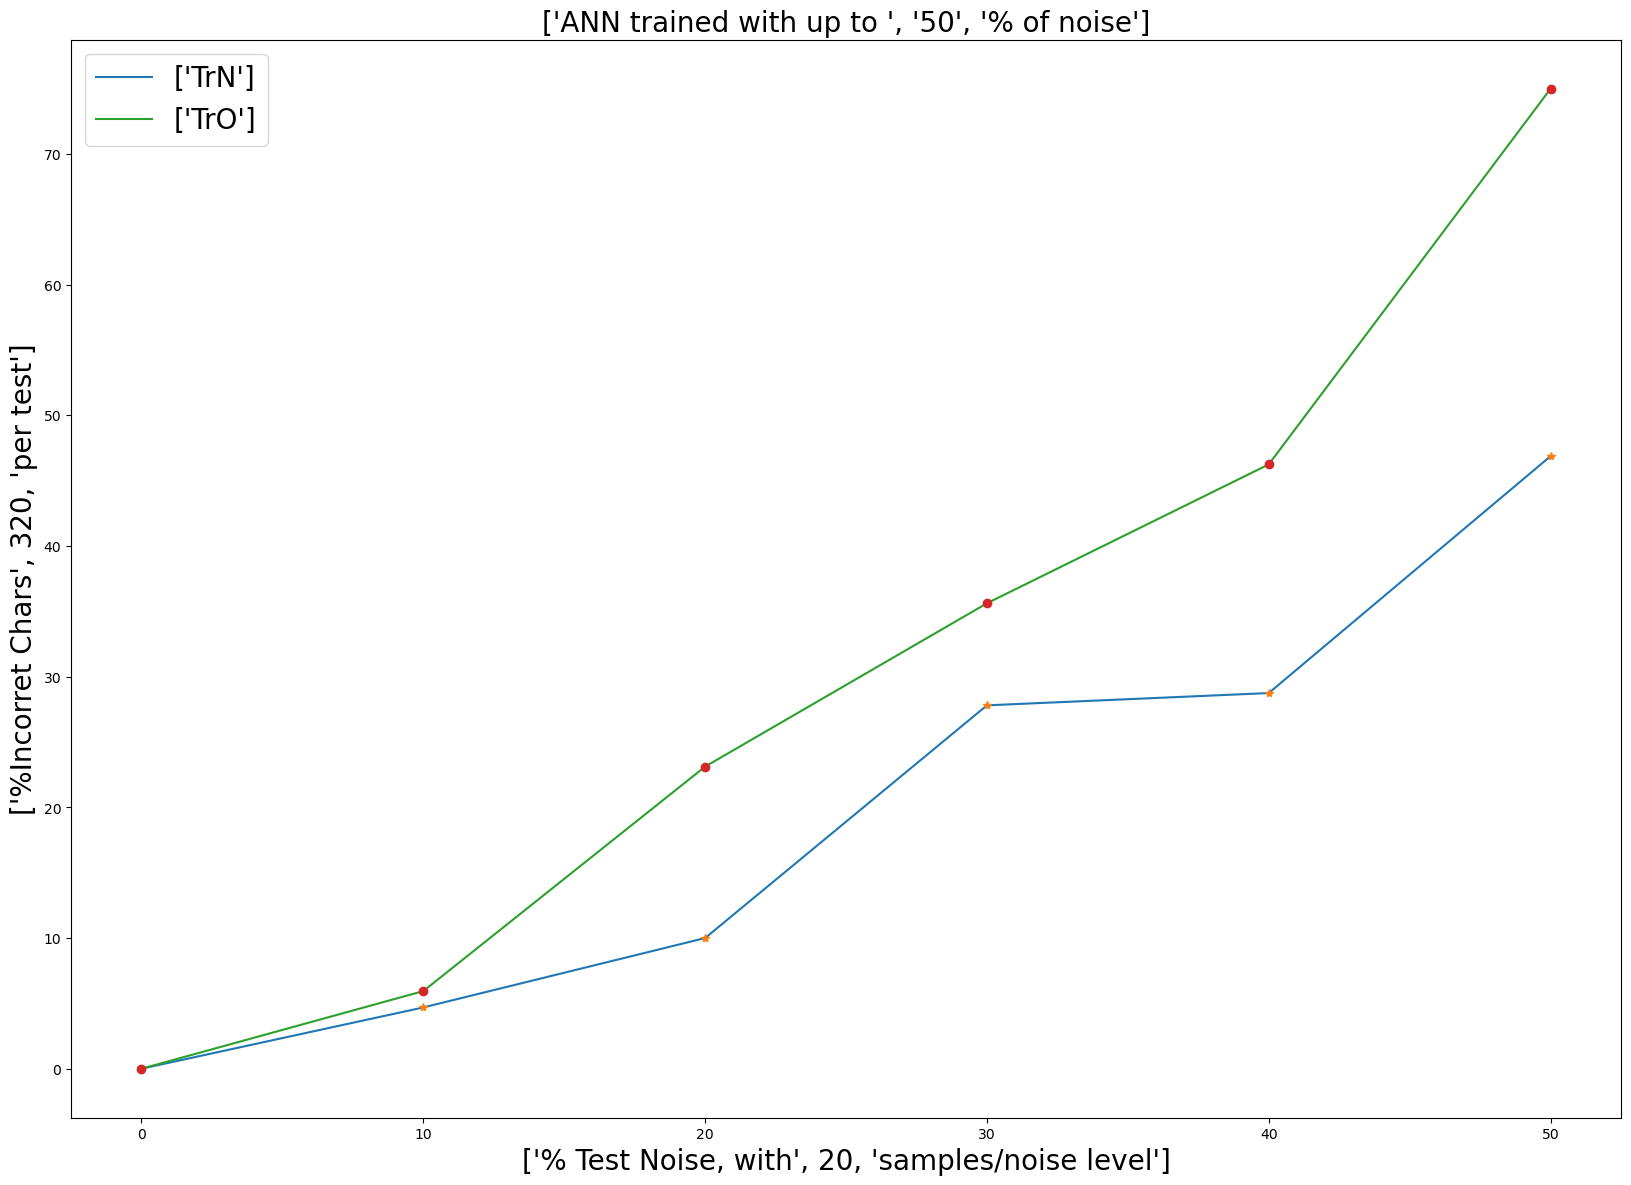

In [215]:
plt.figure(figsize=(20,14))
 
plt.plot(range(0,NStep*N,NStep),FitV, label=['TrN'])
plt.plot(range(0,NStep*N,NStep),FitV,'*')

plt.plot(range(0,NStep*N,NStep),FitO, label=['TrO'])
plt.plot(range(0,NStep*N,NStep),FitO,'o')

plt.title(['ANN trained with up to ' ,'50','% of noise'], fontsize=20)
plt.ylabel(["%Incorret Chars",Nnv*16,'per test'], fontsize=20)
plt.xlabel(['% Test Noise, with',Nnv,'samples/noise level'], fontsize=20)
plt.legend(loc='upper left', fontsize=20)
 
plt.savefig('figANN.pdf')
plt.show()     